In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaNumtaDB/NumtaDB.zip'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as Flatten
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random

import warnings as wrn
wrn.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split

def full_path(path):
    return '/content/training-a/' + path

df = pd.read_csv('/content/training-a.csv')
df['filename'] = df['filename'].apply(full_path)
df = df.iloc[:, [0, 3]]
df = pd.concat([df, pd.get_dummies(df['digit'])], axis = 1)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=32)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"TrainDF: {len(train_df)}\nTestDF: {len(test_df)}\n\n")

df

TrainDF: 15761
TestDF: 3941




,filename,digit,0,1,2,3,4,5,6,7,8,9
0,/content/training-a/a00000.png,5,0,0,0,0,0,1,0,0,0,0
1,/content/training-a/a00001.png,3,0,0,0,1,0,0,0,0,0,0
2,/content/training-a/a00002.png,1,0,1,0,0,0,0,0,0,0,0
3,/content/training-a/a00003.png,7,0,0,0,0,0,0,0,1,0,0
4,/content/training-a/a00004.png,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19697,/content/training-a/a19697.png,4,0,0,0,0,1,0,0,0,0,0
19698,/content/training-a/a19698.png,3,0,0,0,1,0,0,0,0,0,0
19699,/content/training-a/a19699.png,8,0,0,0,0,0,0,0,0,1,0
19700,/content/training-a/a19700.png,3,0,0,0,1,0,0,0,0,0,0


In [ ]:
ROOT_DIR = '/content/training-a/'
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (64, 64)
BATCH_SIZE = 32

N_CLASSES = len(set(df['digit'].values))  # 10

(180, 180, 3)


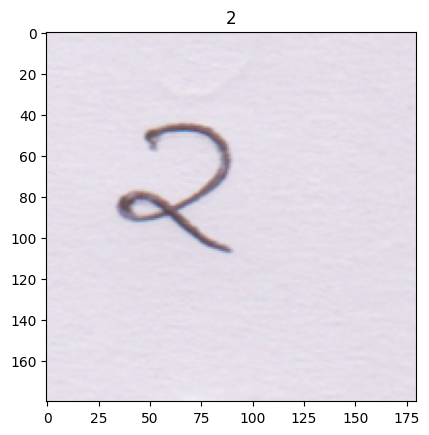

In [ ]:
import matplotlib.pyplot as plt
import random

def imshow():
    idx = random.randint(0, len(train_df))
    img = plt.imread(train_df['filename'][idx])
    label = train_df['digit'][idx]
    print(img.shape)
    plt.imshow(img)
    plt.title(label)
    plt.show()

imshow()

In [ ]:
class CustomDatasetLoader(torch.utils.data.Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 0]
        img = cv2.imread(path)

        if self.transform:
            img = self.transform(img)

        label = torch.from_numpy(self.df.iloc[idx, 2:].values.astype(float))

        return (img, label)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    # torchvision.transforms.CenterCrop((150, 150)),
    torchvision.transforms.Resize(IMG_SIZE),
    torchvision.transforms.ToTensor(),
])

train_data = CustomDatasetLoader(df = train_df, transform = transform)
test_data = CustomDatasetLoader(df = test_df, transform = transform)
all_data = CustomDatasetLoader(df = df.iloc[:, :-1], transform = transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data, batch_size = 32, shuffle = True, num_workers = 1, drop_last = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)
all_data_loader = torch.utils.data.DataLoader(
    dataset = all_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)

In [ ]:
for (images, labels) in all_data_loader:
    print(images.shape)
    print(labels.shape)
    break

all_data.__len__()

torch.Size([64, 3, 64, 64])
torch.Size([64, 9])


19702

In [ ]:
# conv out = ((i+2p-k)/s)+1
# convtrans out = (i-1)*s+k-2p

In [ ]:
class ResizeConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

In [ ]:
class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

In [ ]:
class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 64, 64)
        return x

In [ ]:
# z, mu, logvar, recon_imgs

In [ ]:
class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return z, mean, logvar, x

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [ ]:
model = VAE(z_dim = 64).to(DEVICE)

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,728
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3           [-1, 64, 16, 16]          36,864
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
     BasicBlockEnc-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
    BasicBlockEnc-12           [-1, 64, 16, 16]               0
           Conv2d-13            [-1, 128, 8, 8]          73,728
      BatchNorm2d-14            [-1, 12

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def criterion(recon_img, img, mu, logvar):
    # recon_loss = F.mse_loss(recon_img, img)
    recon_loss = F.binary_cross_entropy(recon_img, img, size_average=False)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1), dim=0)
    return recon_loss+KLD, recon_loss, KLD

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for idx, batch in enumerate(tqdm(iterator)):
        images, _ = batch
        images = images.to(DEVICE)
        optimizer.zero_grad()
        z, mu, logvar, recon_imgs = model(images)
        loss, recon_loss, kld_loss = criterion(recon_imgs, images, mu, logvar)
        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1)
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
best_loss = 1e10
for epoch in range(51):
    if os.path.exists('model.pth'):
        model.load_state_dict(torch.load('model.pth'))
    print(f"Epoch - {epoch}")
    loss = train(model, train_loader, optimizer, criterion)
    print(f"Loss - {loss:.2f}\n")

    if epoch % 10 == 0 and loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch - 0


100%|██████████| 492/492 [00:51<00:00,  9.50it/s]


Loss - 149407.16

--------------------
Model Saved
--------------------
Epoch - 1


100%|██████████| 492/492 [00:50<00:00,  9.67it/s]


Loss - 149092.85

Epoch - 2


100%|██████████| 492/492 [00:50<00:00,  9.83it/s]


Loss - 149133.83

Epoch - 3


100%|██████████| 492/492 [00:49<00:00, 10.01it/s]


Loss - 149135.87

Epoch - 4


100%|██████████| 492/492 [00:49<00:00,  9.97it/s]


Loss - 149191.07

Epoch - 5


100%|██████████| 492/492 [00:48<00:00, 10.18it/s]


Loss - 149190.76

Epoch - 6


100%|██████████| 492/492 [00:49<00:00,  9.89it/s]


Loss - 149169.57

Epoch - 7


100%|██████████| 492/492 [00:48<00:00, 10.19it/s]


Loss - 149199.41

Epoch - 8


100%|██████████| 492/492 [00:51<00:00,  9.61it/s]


Loss - 149231.66

Epoch - 9


100%|██████████| 492/492 [00:48<00:00, 10.11it/s]


Loss - 149223.79

Epoch - 10


100%|██████████| 492/492 [00:49<00:00,  9.85it/s]


Loss - 149246.75

--------------------
Model Saved
--------------------
Epoch - 11


100%|██████████| 492/492 [00:48<00:00, 10.06it/s]


Loss - 148948.15

Epoch - 12


100%|██████████| 492/492 [00:49<00:00,  9.89it/s]


Loss - 148980.39

Epoch - 13


100%|██████████| 492/492 [00:48<00:00, 10.17it/s]


Loss - 148946.75

Epoch - 14


100%|██████████| 492/492 [00:49<00:00,  9.99it/s]


Loss - 148991.26

Epoch - 15


100%|██████████| 492/492 [00:48<00:00, 10.13it/s]


Loss - 148990.39

Epoch - 16


100%|██████████| 492/492 [00:48<00:00, 10.10it/s]


Loss - 149005.66

Epoch - 17


100%|██████████| 492/492 [00:49<00:00,  9.97it/s]


Loss - 149008.52

Epoch - 18


100%|██████████| 492/492 [00:49<00:00,  9.93it/s]


Loss - 148971.44

Epoch - 19


100%|██████████| 492/492 [00:49<00:00,  9.99it/s]


Loss - 148989.96

Epoch - 20


100%|██████████| 492/492 [00:49<00:00, 10.00it/s]


Loss - 149006.17

--------------------
Model Saved
--------------------
Epoch - 21


100%|██████████| 492/492 [00:48<00:00, 10.06it/s]


Loss - 148698.77

Epoch - 22


100%|██████████| 492/492 [00:48<00:00, 10.12it/s]


Loss - 148699.98

Epoch - 23


100%|██████████| 492/492 [00:48<00:00, 10.06it/s]


Loss - 148720.20

Epoch - 24


100%|██████████| 492/492 [00:48<00:00, 10.23it/s]


Loss - 148690.59

Epoch - 25


100%|██████████| 492/492 [00:49<00:00,  9.99it/s]


Loss - 148707.03

Epoch - 26


100%|██████████| 492/492 [00:48<00:00, 10.20it/s]


Loss - 148690.20

Epoch - 27


100%|██████████| 492/492 [00:49<00:00,  9.96it/s]


Loss - 148704.78

Epoch - 28


100%|██████████| 492/492 [00:48<00:00, 10.19it/s]


Loss - 148703.93

Epoch - 29


100%|██████████| 492/492 [00:49<00:00, 10.01it/s]


Loss - 148728.49

Epoch - 30


100%|██████████| 492/492 [00:48<00:00, 10.06it/s]


Loss - 148742.96

--------------------
Model Saved
--------------------
Epoch - 31


100%|██████████| 492/492 [00:50<00:00,  9.80it/s]


Loss - 148487.56

Epoch - 32


100%|██████████| 492/492 [00:50<00:00,  9.70it/s]


Loss - 148496.84

Epoch - 33


100%|██████████| 492/492 [00:50<00:00,  9.66it/s]


Loss - 148498.56

Epoch - 34


100%|██████████| 492/492 [00:48<00:00, 10.15it/s]


Loss - 148498.65

Epoch - 35


100%|██████████| 492/492 [00:49<00:00,  9.97it/s]


Loss - 148506.47

Epoch - 36


100%|██████████| 492/492 [00:48<00:00, 10.14it/s]


Loss - 148504.13

Epoch - 37


100%|██████████| 492/492 [00:49<00:00,  9.97it/s]


Loss - 148477.76

Epoch - 38


100%|██████████| 492/492 [00:48<00:00, 10.13it/s]


Loss - 148515.48

Epoch - 39


100%|██████████| 492/492 [00:48<00:00, 10.09it/s]


Loss - 148502.18

Epoch - 40


 94%|█████████▍| 464/492 [00:46<00:02, 11.02it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ee7a6cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 492/492 [00:49<00:00,  9.92it/s]


Loss - 148504.06

--------------------
Model Saved
--------------------
Epoch - 41


 73%|███████▎  | 358/492 [00:35<00:17,  7.60it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ee7a6cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 492/492 [00:48<00:00, 10.08it/s]


Loss - 148286.42

Epoch - 42


 66%|██████▋   | 327/492 [00:32<00:14, 11.09it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ee7a6cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 492/492 [00:49<00:00, 10.00it/s]


Loss - 148318.50

Epoch - 43


 46%|████▌     | 227/492 [00:22<00:37,  6.98it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ee7a6cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 492/492 [00:48<00:00, 10.11it/s]


Loss - 148290.60

Epoch - 44


 33%|███▎      | 163/492 [00:17<00:49,  6.69it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ee7a6cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 492/492 [00:49<00:00,  9.87it/s]


Loss - 148350.38

Epoch - 45


 12%|█▏        | 61/492 [00:05<00:38, 11.31it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ee7a6cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 492/492 [00:49<00:00, 10.02it/s]


Loss - 148304.87

Epoch - 46


  7%|▋         | 35/492 [00:04<00:44, 10.22it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ee7a6cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 492/492 [00:50<00:00,  9.65it/s]


Loss - 148324.43

Epoch - 47


  1%|          | 6/492 [00:00<00:48, 10.02it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63ee7a6cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 492/492 [00:49<00:00,  9.93it/s]


Loss - 148300.71

Epoch - 48


100%|██████████| 492/492 [00:49<00:00, 10.00it/s]


Loss - 148315.69

Epoch - 49


100%|██████████| 492/492 [00:49<00:00,  9.93it/s]


Loss - 148314.02

Epoch - 50


100%|██████████| 492/492 [00:48<00:00, 10.11it/s]


Loss - 148316.44

--------------------
Model Saved
--------------------


torch.Size([64, 64]) tensor([[-0.9191, -1.5097, -0.1874,  ...,  0.1176,  0.0772, -2.0350],
        [-2.0135, -1.0315, -0.0057,  ..., -1.4130, -0.9781,  0.2456],
        [-1.1816, -0.9978,  0.6374,  ..., -2.0523,  0.0957, -0.6701],
        ...,
        [ 2.2703,  1.4017,  0.3011,  ...,  3.5436, -0.1736, -0.2727],
        [-0.1548,  0.3065, -0.2679,  ..., -3.5300, -0.5833, -0.6082],
        [ 0.1625, -2.8466, -0.5402,  ..., -1.2883,  1.6256, -1.9672]],
       device='cuda:0')


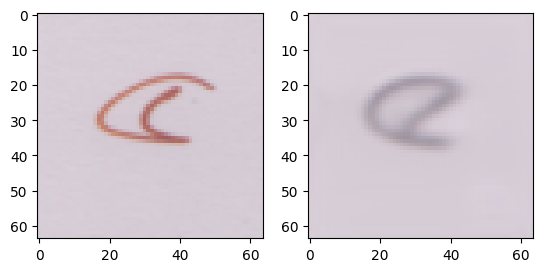

In [ ]:
model.load_state_dict(torch.load('model.pth'))

model.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(DEVICE)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        z, mu, logvar, out = model(imgs)
        print(z.shape, z)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

In [ ]:
new_df = df[['filename', 'digit']]
new_df

,filename,digit
0,/content/training-a/a00000.png,5
1,/content/training-a/a00001.png,3
2,/content/training-a/a00002.png,1
3,/content/training-a/a00003.png,7
4,/content/training-a/a00004.png,0
...,...,...
19697,/content/training-a/a19697.png,4
19698,/content/training-a/a19698.png,3
19699,/content/training-a/a19699.png,8
19700,/content/training-a/a19700.png,3


In [ ]:
def embedding(path):
    img = cv2.imread(path)
    img = transform(img).unsqueeze(0).to(DEVICE)
    z, mu, logvar, out = model(img)
    z = z.squeeze(0).cpu().detach().numpy()
    # mu = mu.squeeze(0).cpu().detach().numpy()
    # return z + mu
    return z

# All Images + All Images (Avg)

In [ ]:
model.load_state_dict(torch.load('model.pth'))

embeddings = []
all_images = new_df['filename'].values

for idx in tqdm(range(len(new_df))):
    img_path = all_images[idx]
    z = embedding(img_path)
    embeddings.append(z)
    # print(z.shape, z)
    # break

100%|██████████| 19702/19702 [03:05<00:00, 106.00it/s]


In [ ]:
embedding_df = pd.DataFrame(embeddings)

merged_df = pd.concat([new_df, embedding_df], axis=1)
merged_df

,filename,digit,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
0,/content/training-a/a00000.png,5,2.107759,-1.622772,0.576307,-1.599842,-0.372622,2.066241,-0.122653,0.078429,...,-0.093707,3.540437,-1.581546,0.984396,0.545003,-0.800315,-1.189447,2.137927,1.571434,-1.491901
1,/content/training-a/a00001.png,3,-0.359821,-0.229197,0.678000,-1.830006,0.231503,0.893187,-0.710633,-0.123028,...,0.857280,-0.126993,-1.270465,-0.681669,1.529364,1.290684,0.237880,2.506566,0.776173,0.568845
2,/content/training-a/a00002.png,1,-1.411513,-1.142713,0.903985,0.617377,0.671918,-0.019280,0.221644,-0.335778,...,-0.074526,-1.613971,1.006345,0.475517,-0.558147,0.094740,-0.058886,-3.835221,1.458799,-0.995208
3,/content/training-a/a00003.png,7,0.260381,-1.132360,-0.826574,0.671079,-1.937640,-1.023996,0.014247,0.265351,...,-1.776955,0.045731,-2.353775,0.641238,-0.590788,0.003913,-1.162614,-1.098346,1.086224,-2.699083
4,/content/training-a/a00004.png,0,-1.649387,-0.456749,0.798345,1.804313,-1.039623,-0.498182,0.766419,1.758250,...,-0.179199,-0.395479,-1.867020,0.077765,0.213056,0.053476,0.100120,-2.586996,0.103074,-1.797732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19697,/content/training-a/a19697.png,4,0.143208,-1.278155,0.589293,1.151318,-0.949321,0.122180,-0.322810,1.115679,...,0.321400,1.184832,2.031521,1.255774,-0.233256,-0.586025,-0.747154,-1.684398,1.449277,-0.027346
19698,/content/training-a/a19698.png,3,-1.388204,-1.885862,0.837545,-2.613768,1.426310,0.596150,0.263688,0.832607,...,0.998101,0.221800,-3.854756,0.485519,3.284207,-0.734597,-0.911267,-0.723068,2.898943,-0.571013
19699,/content/training-a/a19699.png,8,1.442394,-0.223177,0.922539,0.801899,0.697613,-0.158789,-1.639952,1.284343,...,1.257685,0.254112,2.496602,-0.883627,-1.165223,0.075666,0.252305,1.193179,0.748930,-0.857772
19700,/content/training-a/a19700.png,3,1.160656,-0.824530,1.858992,-1.401574,-0.583841,1.866948,0.782967,0.031990,...,0.860646,0.408411,1.050065,0.544479,-0.784375,-0.906052,-0.108856,1.498927,0.958146,-1.856040


In [ ]:
temp_df = merged_df.loc[merged_df['digit'] == 0]
values = temp_df.iloc[:, 2:].values
values = np.sum(values, axis=0)
values = values/len(temp_df)
values

array([-1.9820000e-01, -3.7041062e-01,  4.7358093e-01,  8.6005872e-01,
       -3.9891082e-01, -1.1162801e-01,  6.2613750e-01,  9.1816026e-01,
        5.0398910e-01, -3.8859579e-01,  2.2155677e-01,  1.2393469e+00,
        8.0629083e-04,  6.7041390e-02,  4.0893757e-01, -1.4273193e-02,
       -5.7639682e-01,  3.5157937e-01,  1.1507690e-01, -4.3438309e-01,
       -1.0280482e+00,  4.6868998e-01,  4.6294588e-01,  2.5207427e-01,
        6.9809270e-01,  6.7191690e-01,  8.7334692e-02, -6.9352752e-01,
       -7.1587853e-02, -6.2643182e-01, -7.5116098e-01, -6.9814539e-01,
       -1.5035146e+00,  4.4731668e-01,  7.6715487e-01,  1.3129665e-01,
        8.0330062e-01,  6.5389976e-02,  3.8453728e-02,  6.6165251e-01,
        1.8777215e+00, -7.4422348e-01, -2.9458410e-01,  2.7346626e-01,
        2.5272548e-01,  1.9322921e-01, -4.4891972e-02,  9.5892996e-02,
       -3.4616691e-01, -6.2405097e-01,  6.7407005e-02,  2.9067662e-02,
        4.4370535e-01,  1.5723726e+00, -8.3115011e-02, -3.1738839e-01,
      

In [ ]:
embd_all_images = {}
embd_all_images_avg = {}

for i in range(0, 9+1):
    temp_df = merged_df.loc[merged_df['digit'] == int(i)]
    values = temp_df.iloc[:, 2:].values
    values = np.sum(values, axis=0)

    embd_all_images[i] = values
    embd_all_images_avg[i] = values/len(temp_df)

embd_all_images_df = pd.DataFrame(embd_all_images)
embd_all_images_avg_df = pd.DataFrame(embd_all_images_avg)

# embd_all_images_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaNumtaDB/VAE/EMDB_VAEResnet/embd_all_images.csv', index=False)
# embd_all_images_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaNumtaDB/VAE/EMDB_VAEResnet/embd_all_images_avg_df.csv', index=False)

In [ ]:
embd_all_images_df

,0,1,2,3,4,5,6,7,8,9
0,-391.445007,-644.260986,341.435059,-1054.342041,-1338.916260,-1578.067383,-1459.904907,-86.099075,772.645386,313.452881
1,-731.560974,-2283.714844,-3347.937256,-2095.855469,-2025.829834,-882.297729,-79.440269,-218.673737,-529.275513,-2505.912109
2,935.322327,1493.186279,-250.589584,716.822510,477.399567,694.925293,1270.545654,-191.251556,1241.510742,1319.133423
3,1698.615967,782.734863,-73.599388,-1357.329102,804.078247,11.754677,-1081.097168,974.441406,1018.285522,-855.393799
4,-787.848877,-117.847702,-1604.522339,37.782928,-911.615295,-1596.347656,-95.382683,-2075.830078,1159.852295,-76.369606
...,...,...,...,...,...,...,...,...,...,...
59,270.638611,-344.994080,79.854797,-206.023117,-752.086060,-378.193176,93.419289,121.196884,-211.663635,-444.688232
60,-386.932343,-715.003174,-1085.677002,-827.940979,-1525.580811,-1051.665894,-324.921143,-1249.595215,-1345.070312,-842.130249
61,-2357.691406,-1328.819092,882.158203,-585.057068,-1083.296509,129.463348,-280.936066,313.181641,1164.356201,601.029785
62,-827.083374,539.111694,1769.412598,1741.550781,1671.454834,615.999146,1262.984375,753.489990,752.659424,1565.438232


In [ ]:
embd_all_images_avg_df

,0,1,2,3,4,5,6,7,8,9
0,-0.198200,-0.328202,0.172094,-0.533574,-0.675538,-0.803088,-0.736210,-0.043928,0.396228,0.159599
1,-0.370411,-1.163380,-1.687468,-1.060656,-1.022114,-0.449006,-0.040061,-0.111568,-0.271423,-1.275923
2,0.473581,0.760665,-0.126305,0.362764,0.240868,0.353652,0.640719,-0.097577,0.636672,0.671657
3,0.860059,0.398744,-0.037096,-0.686907,0.405690,0.005982,-0.545183,0.497164,0.522198,-0.435537
4,-0.398911,-0.060034,-0.808731,0.019121,-0.459947,-0.812391,-0.048100,-1.059097,0.594796,-0.038885
...,...,...,...,...,...,...,...,...,...,...
59,0.137032,-0.175748,0.040249,-0.104263,-0.379458,-0.192465,0.047110,0.061835,-0.108545,-0.226420
60,-0.195915,-0.364240,-0.547216,-0.418998,-0.769718,-0.535199,-0.163853,-0.637549,-0.689780,-0.428783
61,-1.193768,-0.676933,0.444636,-0.296082,-0.546567,0.065885,-0.141672,0.159787,0.597106,0.306023
62,-0.418776,0.274637,0.891841,0.881352,0.843317,0.313486,0.636906,0.384434,0.385979,0.797066


In [ ]:
# pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaNumtaDB/VAE/EMDB_VAEResnet/embd_all_images_avg_df.csv')

In [ ]:
# pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaNumtaDB/VAE/EMDB_VAEResnet/embd_all_images.csv')